Fourier correlation of lagged signals
===============

This is a test notebook
to try out the Fourier correlation approach
to estimating a time delay
between the same signal received at two antennas or microphones
or whatever.

In [1]:
try:
    del stem
except Exception:
    pass

%pylab inline
rcParams['figure.figsize'] = (15, 2)

Populating the interactive namespace from numpy and matplotlib


First, let's make a signal.  This one is pretty impulsive, but dc-balanced,
which are both beneficial features for estimating the delay.

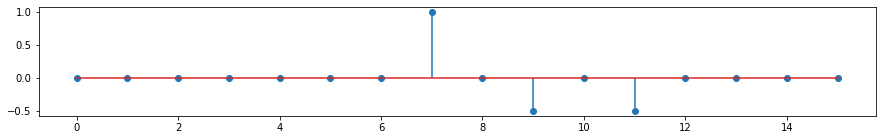

In [2]:
original = zeros(16)
original[7] = 1
original[9] = -0.5
original[11] = -0.5
def stem(*args):
    # shut up the stupid fucking warning
    pyplot.stem(*args, use_line_collection=True)
    
stem(original)

Now we generate a delayed version of the signal.  In this case we're delaying by an integer number of samples
because that's simpler.  Also we're using a circular shift, which would make the math come out perfect
even if the samples shifted off the end *weren't* zeroes.


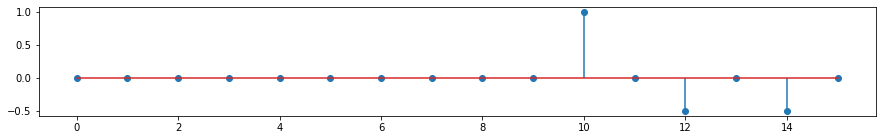

In [3]:
delayed = roll(original, 3)
stem(delayed)

Now we take the Fourier transform of both signals.  We can see that the magnitude of their frequency content is
exactly the same, because a time delay only affects the phase, not the magnitude of each frequency:

array([ 0.        +0.j        , -0.27059805-1.03596491j,
        0.70710678+1.41421356j, -0.65328148-1.19447758j,
        0.        +1.j        ,  0.65328148-1.19447758j,
       -0.70710678+1.41421356j,  0.27059805-1.03596491j,
        0.        +0.j        ,  0.27059805+1.03596491j,
       -0.70710678-1.41421356j,  0.65328148+1.19447758j,
        0.        -1.j        , -0.65328148+1.19447758j,
        0.70710678-1.41421356j, -0.27059805+1.03596491j])

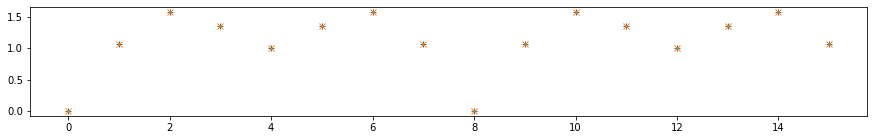

In [4]:
ot = fft.fft(original)   # original, transformed to the frequency domain
dt = fft.fft(delayed)    # delayed, transformed
plot(abs(ot), '+')
plot(abs(dt), 'x')
ot

But if we plot, say, just the real or imaginary part of each signal, we'll see that they are quite different:

array([ 0.        , -0.27059805,  0.70710678, -0.65328148,  0.        ,
        0.65328148, -0.70710678,  0.27059805,  0.        ,  0.27059805,
       -0.70710678,  0.65328148,  0.        , -0.65328148,  0.70710678,
       -0.27059805])

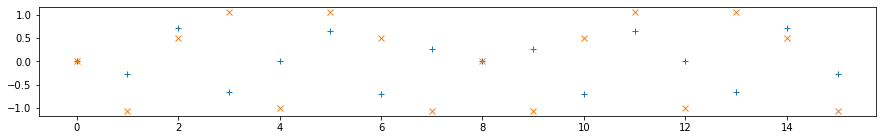

In [5]:
plot(ot.real, '+')
plot(dt.real, 'x')
ot.real

Frequency-domain conjugation is time-domain time reversal,
correlation is convolution with time reversal, 
and frequency-domain elementwise multiplication is time-domain convolution,
we can multiply the original signal's frequency spectrum
with the conjugate of the delayed signal's frequency spectrum
to get the correlation's frequency spectrum:

array([ 0.        +0.j        ,  0.43872612+1.05917856j,
       -1.76776695+1.76776695j, -1.71246004-0.70932417j,
        0.        -1.j        ,  1.71246004-0.70932417j,
        1.76776695+1.76776695j, -0.43872612+1.05917856j,
        0.        +0.j        , -0.43872612-1.05917856j,
        1.76776695-1.76776695j,  1.71246004+0.70932417j,
       -0.        +1.j        , -1.71246004+0.70932417j,
       -1.76776695-1.76776695j,  0.43872612-1.05917856j])

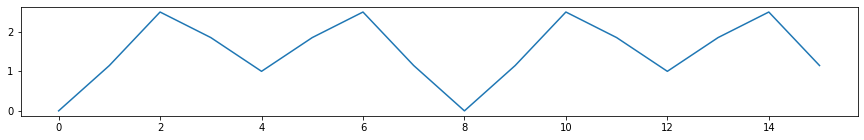

In [6]:
ct = ot * dt.conj()  # correlation, transformed
plot(abs(ct))
ct

So far that doesn't look like much of anything.  But if we take the inverse Fourier transform, we can see that
it has a single strong peak at -3.  This is actually the opposite of the direction I expected.

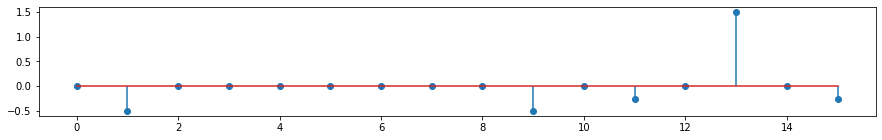

In [7]:
stem(fft.ifft(ct).real)

Random white-noise signals are nearly optimal
----------

Now let's try the exercise with a signal that looks like noise, which should be ideal because its
autocorrelation should have a single nice sharp peak.

array([ 0.08849036,  0.4300979 , -0.20882384, -0.137711  , -0.01851827])

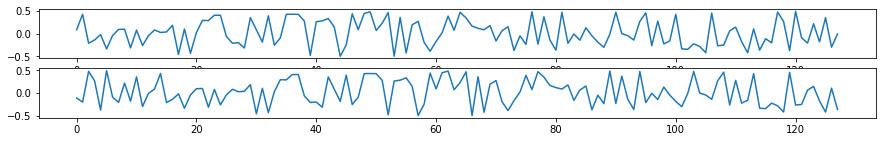

In [8]:
ns = np.random.random(128) - 0.5  # noiselike signal
dns = roll(ns, 13)                # delayed noiselike signal
subplot(211); plot(ns)
subplot(212); plot(dns)
ns[:5]

And this time let's take the conjugate of the
un-delayed signal so our peak's location is at a more easily interpretable location.

13

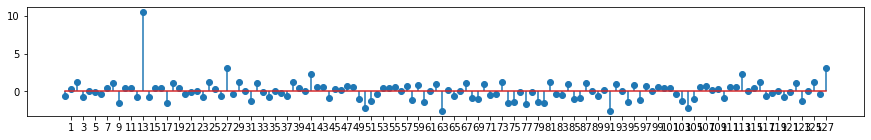

In [26]:
fns = fft.fft(ns)          # frequency-domain noiselike signal
fdns = fft.fft(dns)        # frequency-domain delayed noiselike signal
fcns = fns.conj() * fdns   # frequency-domain correlation of noiselike signal
cns = fft.ifft(fcns).real  # correlation of noiselike signal; any imaginary part is a rounding error
stem(cns); xticks(arange(1, len(cns), 2))
cns.argmax()

### It works even if there is interfering noise ###

Let's try adding some noise to the signals.  Actual noise, not just a desired signal with a broad spectrum.
We're going to subtract 0.5 because that's the mean of the noise and a DC constant level is highly correlated
with itself everywhere.

13

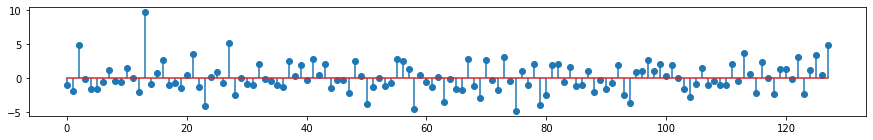

In [10]:
fnsi = fft.fft(ns + random.random(len(ns)) - 0.5)     # frequency-domain noiselike signal with interference
fdnsi = fft.fft(dns + random.random(len(ns)) - 0.5)
fcnsi = fnsi.conj() * fdnsi
cnsi = fft.ifft(fcnsi)
stem(cnsi)
cnsi.argmax()

As you can see, it's not quite as clean as before, but it still easily finds the common signal, even though we've
added as much noise to the signal as was in the original signal.

Periodic signals: the worst case
--------

A random signal is almost the best case, though there are quasirandom signals like M-sequences that are even better.
The worst case is a periodic signal of some kind, like a sine wave.

array([1.        , 0.99826561, 0.99306846, 0.98442657, 0.97236992,
       0.95694034, 0.93819134, 0.91618796, 0.89100652, 0.86273439])

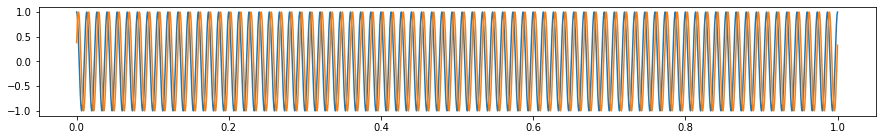

In [11]:
fs = 8000                      # sampling frequency
t = arange(fs) / fs            # time, in seconds
w = cos(2 * pi * 75 * t)
plot(t, w)
dw = roll(w, 20)
plot(t, dw)
w[:10]

The delay between the waves is hard to see there, so let's zoom in.

array([0.38268343, 0.43640924, 0.48862124, 0.53913832, 0.58778525,
       0.63439328, 0.67880075, 0.7208536 , 0.76040597, 0.79732065])

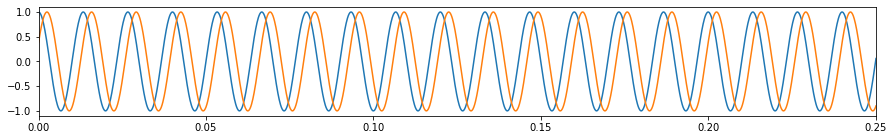

In [12]:
xlim(0, 0.25)
plot(t, w, t, dw)
dw[:10]

So what does it look like if we do the same Fourier correlation trick as before?  Total shite, that's what.

(2580, 20)

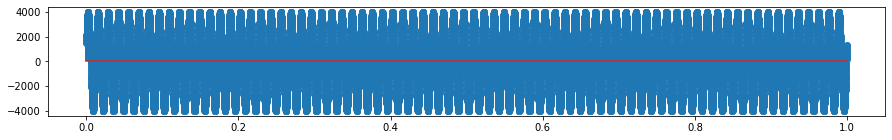

In [13]:
fw = fft.fft(w)   # grr!  meow?
fdw = fft.fft(dw)
fcw = fw.conj() * fdw
cw = fft.ifft(fcw)
stem(t, cw)
cw.argmax(), abs(cw).argmax()

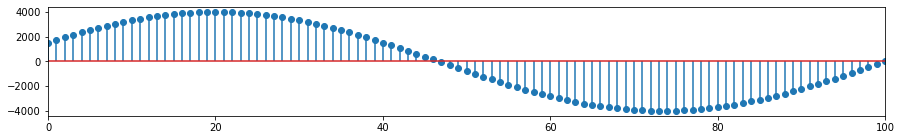

In [14]:
xlim(0, 100)
stem(cw)

I mean yes there's a correlation
peak at 20 samples?  But it's not much of a peak, and there are equally strong peaks in many other
places.

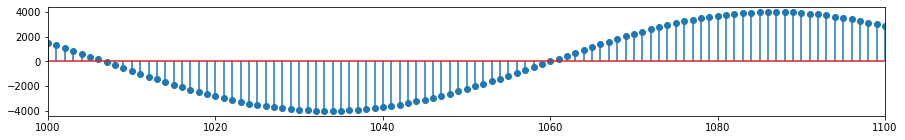

In [15]:
xlim(1000, 1100)
stem(cw)

### Windowing the sine wave ###

Applying a window function before the Fourier transform doesn't help a whole lot.
First let's see what the windowed signal looks like:

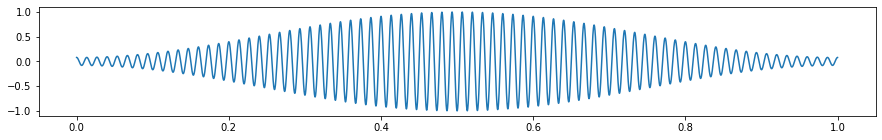

In [16]:
ww = hamming(len(w)) * w   # windowed wave-like signal
plot(t, ww)

(20, 20)

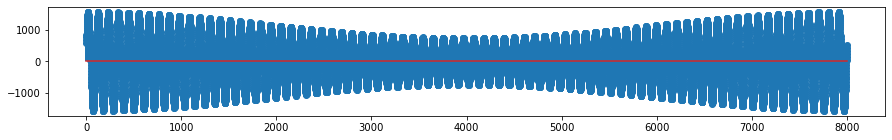

In [17]:
wdw = hamming(len(w)) * dw
fww = fft.fft(ww)
fwdw = fft.fft(wdw)
fwcw = fww.conj() * fwdw
wcw = fft.ifft(fwcw)
stem(wcw)
wcw.argmax(), abs(wcw).argmax()

This breaks the tie, but it breaks it in favor of smaller shifts, not in favor of better matches,
because all the matches are exactly as good!

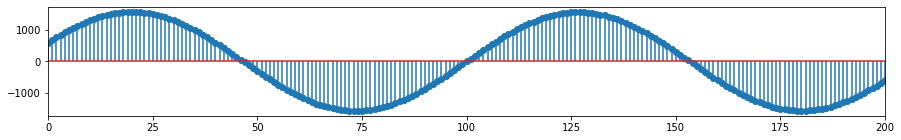

In [18]:
xlim(0, 200)
stem(wcw)

Chirps
----------

An interesting thing is what happens if we use a chirp signal instead of a pure tone.
Let's increase the frequency from 75 Hz to 95 Hz over the course of a second.

We can do this by calculating a time-varying phase $\omega$ whose time derivative increases from $2\pi 75$
to $2\pi 95$, then taking its sine or cosine.  We can confirm that we've done this correctly by plotting
a discrete approximation to the derivative.

array([0.        , 0.02945292, 0.05890683, 0.08836171, 0.11781758,
       0.14727443, 0.17673226, 0.20619107, 0.23565086, 0.26511164])

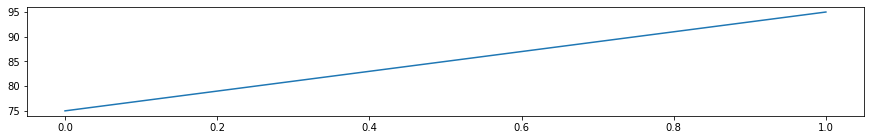

In [19]:
cso = pi * (75*t + 10*t**2)
plot(t[1:], diff(cso)/diff(t)/pi)
cso[:10]

array([1.        , 0.99956629, 0.99826549, 0.99609864, 0.99306753,
       0.98917471, 0.98442346, 0.97881783, 0.97236259, 0.96506326])

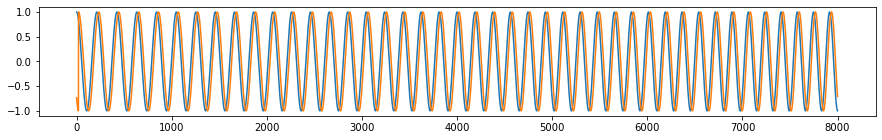

In [20]:
cs = cos(cso)
plot(cs)
dcs = roll(cs, 20)
plot(dcs)
cs[:10]

This looks almost exactly the same to the eye!  Except for the glitch where the cyclically shifted signal
is $180\deg$ out of phase, anyway.  But the correlation function tells a very different story:

20

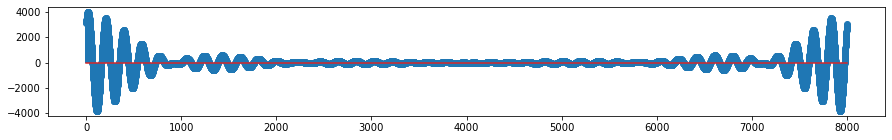

In [27]:
def fxcorr(f, g):
    ff = fft.fft(f)
    fg = fft.fft(g)
    fc = ff.conj() * fg
    return fft.ifft(fc).real

ccs = fxcorr(cs, dcs)
stem(ccs)
ccs.argmax()

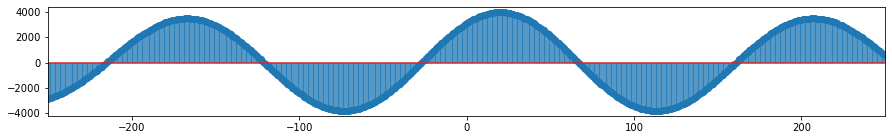

In [22]:
xlim(-250, 250)
stem(arange(-250, len(ccs)-250), roll(ccs, 250))

Chirp signals have this very interesting property that, like impulses or noise, they have very low
autocorrelation except at very small signal shifts; but their peak transmitted power is just their average
transmitted power.  This is a favorable property for radar and sonar, where your transmitter has some
limited peak power that you would like to exploit to the max.
